In [43]:
import torch
import random
import numpy as np
import pandas as pd
!pip install janome
from janome.tokenizer import Tokenizer


import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [44]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

enforce_reproducibility()

dataset_train       = pd.read_parquet("/content/nlp-project-group15/week_2/dataset/train.parquet")
dataset_validation  = pd.read_parquet("/content/nlp-project-group15/week_2/dataset/train.parquet")

questions_fi = dataset_train.loc[(dataset_train["lang"] == "fi")]["question"].apply(lambda row: ['<s>'] + nltk.word_tokenize(row) + ['</s>']).to_list()
questions_fi = [item for sublist in questions_fi for item in sublist]


a = dataset_validation.loc[(dataset_validation["lang"] == "ja")]["question"].to_list()
a[0]

'ポーランドで農地改革が行われたことがある？'

In [155]:
finnish_sentences = dataset_train.loc[dataset_train["lang"] == "fi"]["question"].tolist()
russian_sentences = dataset_train.loc[dataset_train["lang"] == "ru"]["question"].tolist()
japanese_sentences = dataset_train.loc[dataset_train["lang"] == "ja"]["question"].tolist()

# Finnish

## NOT SURE.-[ 1-gram model ] - [ No smoothing ] - Finnish

In [136]:
def calc_unigram_probabilities(dataset_train):
    questions_fi = dataset_train.loc[(dataset_train["lang"] == "fi")]["question"].apply(lambda row: nltk.word_tokenize(row, language='finnish')).to_list()
    tokens = [item.lower() for sublist in questions_fi for item in sublist]

    counts = {}
    for token in tokens:
        if token not in counts.keys():
            counts[token] = 1
        else:
            counts[token] += 1
    token_list_size = len(tokens)

    for count in counts:
        counts[count] = counts[count] / token_list_size

    return counts

model = calc_unigram_probabilities(dataset_train)


def unigram_model_fi(model,text):
    log_sentence_probability = 0.0
    OOV_default_prob = 1e-6

    for token in nltk.word_tokenize(text):
        if token.lower() in model:
            token_prob = model[token.lower()]  # Use a small value for unknown words

        else:
            token_prob = OOV_default_prob
        log_sentence_probability += np.log(token_prob)

    return log_sentence_probability


unigram_model_fi(model,'Missä maassa Jack Churchill syntyi?')


-46.74348697097472

In [77]:
model = calc_unigram_probabilities(dataset_train)
finnish_log_prob_uni = []
for sentence in finnish_sentences:
  finnish_log_prob_uni.append(unigram_model_fi(model, sentence))

[-31.39958070858296,
 -67.06304761451217,
 -59.87935650017975,
 -54.9418646618389,
 -39.37333116576731,
 -29.93769799013892,
 -90.46854304804242,
 -43.29365297401015,
 -42.28813110840806,
 -34.558395777023,
 -34.06414579774543,
 -61.44351459088015,
 -45.71402110266059,
 -44.99010226343388,
 -45.52090983844525,
 -79.12055870046126,
 -29.24730184295086,
 -61.99160038793209,
 -36.41021600267923,
 -51.81184566575947,
 -42.981278288968,
 -53.920174953508074,
 -91.89169878388721,
 -58.95240390763452,
 -38.510801610784604,
 -35.16370642934358,
 -36.96750350085505,
 -76.12071787077411,
 -44.343449483426674,
 -42.95715512230678,
 -46.95574401608253,
 -32.05860282530132,
 -42.838177445327325,
 -69.22985873455241,
 -48.13749431220845,
 -45.12048990337892,
 -64.63222258330825,
 -36.77314434177768,
 -54.75527519191639,
 -39.64344822829107,
 -35.88565205980235,
 -42.82712760914074,
 -45.51082104179291,
 -34.20072133275119,
 -33.28443060087703,
 -34.464305853623905,
 -24.861710703779128,
 -62.1357007

## FI-1.- [ 2-gram model ] - [ No smoothing ] - Finnish

In [137]:
def calc_bigram_probabilities(dataset_train):
    questions_fi = dataset_train.loc[(dataset_train["lang"] == "fi")]["question"].apply(lambda row: ['<s>'] + nltk.word_tokenize(row, language='finnish') + ['</s>']).to_list()
    tokens = [item.lower() for sublist in questions_fi for item in sublist]

    counts = {}
    for token in tokens:
        if token not in counts.keys():
            counts[token] = 1
        else:
            counts[token] += 1

    bigram_probs = {}
    for token_st, token_nd in zip(tokens,tokens[1:]):
        bigram = (token_st,token_nd)
        if bigram not in bigram_probs.keys():
            bigram_probs[bigram] = 1
        else:
            bigram_probs[bigram] += 1

    for bigram in bigram_probs:
        first = bigram[0]
        bigram_probs[bigram] = bigram_probs[bigram]/counts[first]

    return bigram_probs

model = calc_bigram_probabilities(dataset_train)

def bigram_model_fi(model, text):
    tokens = nltk.word_tokenize(text, language='finnish')
    tokens = ['<s>'] + [token.lower() for token in tokens]  + ['</s>']

    bigrams = [(token_st,token_nd) for token_st,token_nd in  zip(tokens,tokens[1:])]

    log_sentence_probability = 0.0
    OOV_default_prob = 1e-6

    for bigram in bigrams:
        if bigram in model:
            bigram_prob = model[bigram]
        else:
            bigram_prob = OOV_default_prob
        log_sentence_probability += np.log(bigram_prob)

    return log_sentence_probability

bi_fi_no_smoothing = bigram_model_fi(model,'Missä maassa Jack Churchill syntyi?')


In [79]:
model = calc_bigram_probabilities(dataset_train)

finnish_log_prob_bi_no_smoothing = []

for sentence in finnish_sentences:
  finnish_log_prob_bi_no_smoothing.append(bigram_model_fi(model, sentence))


## FI-2.- [ 2-gram model ] - [ Laplace smoothing ] - Finnish

In [138]:
def calc_bigram_probabilities(train_dataset):
    questions_fi = dataset_train.loc[(dataset_train["lang"] == "fi")]["question"].apply(lambda row: ['<s>'] + nltk.word_tokenize(row, language='finnish') + ['</s>']).to_list()
    tokens = [item.lower() for sublist in questions_fi for item in sublist]

    unigram_counts = {}
    for token in tokens:
        if token not in unigram_counts.keys():
            unigram_counts[token] = 1
        else:
            unigram_counts[token] += 1

    V = len(unigram_counts)


    bigram_counts = {}
    for token_st, token_nd in zip(tokens, tokens[1:]):
        bigram = (token_st, token_nd)
        if bigram not in bigram_counts:
            bigram_counts[bigram] = 1
        else:
            bigram_counts[bigram] += 1


    bigram_probs = {}


    for token_st in unigram_counts:
        for token_nd in unigram_counts:
            bigram = (token_st, token_nd)
            count_bigram = bigram_counts[bigram] if bigram in bigram_counts else 0
            bigram_probs[bigram] = (count_bigram + 1) / (unigram_counts[token_st] + V)

    return bigram_probs

model = calc_bigram_probabilities(dataset_train)

def bigram_model_fi_smoothing(model, text):
    tokens = nltk.word_tokenize(text, language='finnish')
    tokens = ['<s>'] + [token.lower() for token in tokens]  + ['</s>']


    bigrams = [(token_st,token_nd) for token_st,token_nd in  zip(tokens,tokens[1:])]

    log_sentence_probability = 0.0
    OOV_default_prob = 1e-6

    for bigram in bigrams:
        if bigram in model:
            bigram_prob = model[bigram]
        else:
            bigram_prob = OOV_default_prob
        log_sentence_probability += np.log(bigram_prob)

    return log_sentence_probability

bi_fi_smoothing = bigram_model_fi_smoothing(model,'Missä maassa Jack Churchill syntyi?')


In [84]:
model = calc_bigram_probabilities(dataset_train)

finnish_log_prob_bi_smoothing = []

for sentence in finnish_sentences:
  finnish_log_prob_bi_smoothing.append(bigram_model_fi_smoothing(model, sentence))

# Russian

## [1-gram model ] - [ No smoothing ] - Russian

In [205]:
def calc_unigram_probabilities(dataset_train):
    questions_ru = dataset_train.loc[(dataset_train["lang"] == "ru")]["question"].apply(lambda row: nltk.word_tokenize(row, language='russian')).to_list()
    tokens = [item.lower() for sublist in questions_ru for item in sublist]

    counts = {}
    for token in tokens:
        if token not in counts.keys():
            counts[token] = 1
        else:
            counts[token] += 1
    token_list_size = len(tokens)

    for count in counts:
        counts[count] = counts[count] / token_list_size

    return counts

model = calc_unigram_probabilities(dataset_train)


def unigram_model_ru(model,text):
    log_sentence_probability = 0.0
    OOV_default_prob = 1e-6

    for token in nltk.word_tokenize(text):
        if token.lower() in model:
            token_prob = model[token.lower()]  # Use a small value for unknown words

        else:
            token_prob = OOV_default_prob
        log_sentence_probability += np.log(token_prob)

    return log_sentence_probability


In [206]:
model = calc_unigram_probabilities(dataset_train)
russian_log_prob_uni = []
for sentence in finnish_sentences:
  russian_log_prob_uni.append(unigram_model_ru(model, sentence))

## RU-1.- [ 2-gram model ] - [ No smoothing ] - Russian

In [139]:
def calc_bigram_probabilities(dataset_train):
    questions_ru = dataset_train.loc[(dataset_train["lang"] == "ru")]["question"].apply(lambda row: ['<s>'] + nltk.word_tokenize(row, language='russian') + ['</s>']).to_list()
    tokens = [item.lower() for sublist in questions_ru for item in sublist]

    counts = {}
    for token in tokens:
        if token not in counts.keys():
            counts[token] = 1
        else:
            counts[token] += 1

    bigram_probs = {}
    for token_st, token_nd in zip(tokens,tokens[1:]):
        bigram = (token_st,token_nd)
        if bigram not in bigram_probs.keys():
            bigram_probs[bigram] = 1
        else:
            bigram_probs[bigram] += 1

    for bigram in bigram_probs:
        first = bigram[0]
        bigram_probs[bigram] = bigram_probs[bigram]/counts[first]

    return bigram_probs

model = calc_bigram_probabilities(dataset_train)

def bigram_model_ru(model, text):
    tokens = nltk.word_tokenize(text, language='russian')
    tokens = ['<s>'] + [token.lower() for token in tokens]  + ['</s>']

    bigrams = [(token_st,token_nd) for token_st,token_nd in  zip(tokens,tokens[1:])]

    log_sentence_probability = 0.0
    OOV_default_prob = 1e-6

    for bigram in bigrams:
        if bigram in model:
            bigram_prob = model[bigram]
        else:
            bigram_prob = OOV_default_prob
        log_sentence_probability += np.log(bigram_prob)

    return log_sentence_probability

bi_ru_no_smoothing = bigram_model_ru(model,'Где вручается Шно́белевская премия ?')


In [87]:
model = calc_bigram_probabilities(dataset_train)

russian_log_prob_bi_no_smoothing = []

for sentence in russian_sentences:
  russian_log_prob_bi_no_smoothing.append(bigram_model_ru(model, sentence))

## RU-2.- [ 2-gram model ] - [ Laplace smoothing ] - Russian

In [140]:
def calc_bigram_probabilities(dataset_train):
    questions_ru = dataset_train.loc[(dataset_train["lang"] == "ru")]["question"].apply(lambda row: ['<s>'] + nltk.word_tokenize(row, language='russian') + ['</s>']).to_list()
    tokens = [item.lower() for sublist in questions_ru for item in sublist]

    unigram_counts = {}
    for token in tokens:
        if token not in unigram_counts.keys():
            unigram_counts[token] = 1
        else:
            unigram_counts[token] += 1

    V = len(unigram_counts)


    bigram_counts = {}
    for token_st, token_nd in zip(tokens, tokens[1:]):
        bigram = (token_st, token_nd)
        if bigram not in bigram_counts:
            bigram_counts[bigram] = 1
        else:
            bigram_counts[bigram] += 1


    bigram_probs = {}


    for token_st in unigram_counts:
        for token_nd in unigram_counts:
            bigram = (token_st, token_nd)
            count_bigram = bigram_counts[bigram] if bigram in bigram_counts else 0
            bigram_probs[bigram] = (count_bigram + 1) / (unigram_counts[token_st] + V)

    return bigram_probs

model = calc_bigram_probabilities(dataset_train)

def bigram_model_ru_smoothing(model, text):
    tokens = nltk.word_tokenize(text, language='russian')
    tokens = ['<s>'] + [token.lower() for token in tokens]  + ['</s>']


    bigrams = [(token_st,token_nd) for token_st,token_nd in  zip(tokens,tokens[1:])]

    log_sentence_probability = 0.0
    OOV_default_prob = 1e-6

    for bigram in bigrams:
        if bigram in model:
            bigram_prob = model[bigram]
        else:
            bigram_prob = OOV_default_prob
        log_sentence_probability += np.log(bigram_prob)

    return log_sentence_probability

bi_ru_smoothing = bigram_model_ru_smoothing(model,'Где вручается Шно́белевская премия ?')


In [132]:
russian_log_prob_bi_smoothing = []

for sentence in russian_sentences:
  russian_log_prob_bi_smoothing.append(bigram_model_ru_smoothing(model, sentence))

# Japanese

## JA-1.- [ 2-gram model ] - [ No smoothing ] - Japanese

In [147]:

def calc_bigram_probabilities(train_dataset):
    tokenizer = Tokenizer()
    questions_ja = train_dataset.loc[(dataset_train["lang"] == "ja")]["question"].apply(lambda row: ['<s>'] + [token.surface for token in tokenizer.tokenize(row)] + ['</s>']).to_list()
    tokens = [item.lower() for sublist in questions_ja for item in sublist]

    counts = {}
    for token in tokens:
        if token not in counts.keys():
            counts[token] = 1
        else:
            counts[token] += 1

    bigram_probs = {}
    for token_st, token_nd in zip(tokens,tokens[1:]):
        bigram = (token_st,token_nd)
        if bigram not in bigram_probs.keys():
            bigram_probs[bigram] = 1
        else:
            bigram_probs[bigram] += 1

    for bigram in bigram_probs:
        first = bigram[0]
        bigram_probs[bigram] = bigram_probs[bigram]/counts[first]

    return bigram_probs

model = calc_bigram_probabilities(dataset_train)

def bigram_model_ja(model, text):
    tokenizer = Tokenizer()
    tokens = [token.surface for token in tokenizer.tokenize(text)]
    tokens = ['<s>'] + tokens  + ['</s>']

    bigrams = [(token_st,token_nd) for token_st,token_nd in  zip(tokens,tokens[1:])]

    log_sentence_probability = 0.0
    OOV_default_prob = 1e-6

    for bigram in bigrams:
        if bigram in model:
            bigram_prob = model[bigram]
        else:
            bigram_prob = OOV_default_prob
        log_sentence_probability += np.log(bigram_prob)

    return log_sentence_probability

bi_ja_no_smoothing = bigram_model_ja(model,'月の地表の温度は何度')

In [156]:
japanese_log_prob_bi_no_smoothing = []

for sentence in japanese_sentences:
  japanese_log_prob_bi_no_smoothing.append(bigram_model_ja(model, sentence))

## JA-2.- [ 2-gram model ] - [ Laplace smoothing ] - Japanese

In [158]:
def calc_bigram_probabilities(train_dataset):
    tokenizer = Tokenizer()
    questions_ja = train_dataset.loc[(dataset_train["lang"] == "ja")]["question"].apply(lambda row: ['<s>'] + [token.surface for token in tokenizer.tokenize(row)] + ['</s>']).to_list()
    tokens = [item.lower() for sublist in questions_ja for item in sublist]

    unigram_counts = {}
    for token in tokens:
        if token not in unigram_counts.keys():
            unigram_counts[token] = 1
        else:
            unigram_counts[token] += 1

    V = len(unigram_counts)


    bigram_counts = {}
    for token_st, token_nd in zip(tokens, tokens[1:]):
        bigram = (token_st, token_nd)
        if bigram not in bigram_counts:
            bigram_counts[bigram] = 1
        else:
            bigram_counts[bigram] += 1


    bigram_probs = {}


    for token_st in unigram_counts:
        for token_nd in unigram_counts:
            bigram = (token_st, token_nd)
            count_bigram = bigram_counts[bigram] if bigram in bigram_counts else 0
            bigram_probs[bigram] = (count_bigram + 1) / (unigram_counts[token_st] + V)

    return bigram_probs

model = calc_bigram_probabilities(dataset_train)

def bigram_model_ja_smoothing(model, text):
    tokenizer = Tokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = ['<s>'] + [token for token in tokens]  + ['</s>']


    bigrams = [(token_st,token_nd) for token_st,token_nd in  zip(tokens,tokens[1:])]

    log_sentence_probability = 0.0
    OOV_default_prob = 1e-6

    for bigram in bigrams:
        if bigram in model:
            bigram_prob = model[bigram]
        else:
            bigram_prob = OOV_default_prob
        log_sentence_probability += np.log(bigram_prob)

    return log_sentence_probability

bi_ja_smoothing = bigram_model_ja_smoothing(model,'月の地表の温度は何度')

In [159]:
japanese_log_prob_bi_smoothing = []

for sentence in japanese_sentences:
  japanese_log_prob_bi_smoothing.append(bigram_model_ja_smoothing(model, sentence))

# Metrics

In [160]:
import numpy as np

def calculate_perplexity(log_probabilities, sentences):
    """
    Calculates perplexity for a set of sentences given their log-probabilities.

    Parameters:
    - log_probabilities: list of float, log-probabilities for each sentence
    - sentences: list of str, sentences corresponding to the log-probabilities

    Returns:
    - Perplexity (float) for the set of sentences
    """
    # Count total words across all sentences
    total_words = sum(len(sentence) for sentence in sentences)

    # Calculate average log-probability per word
    avg_log_prob_per_word = sum(log_probabilities) / total_words

    # Calculate perplexity
    perplexity = np.exp(-avg_log_prob_per_word)

    return perplexity

In [209]:
perplexity_fi_unigram = calculate_perplexity(finnish_log_prob_uni, finnish_sentences)
perplexity_fi_bigram = calculate_perplexity(finnish_log_prob_bi_no_smoothing, finnish_sentences)
perplexity_fi_bigram_smoothed = calculate_perplexity(finnish_log_prob_bi_smoothing, finnish_sentences)

perplexity_ru_unigram = calculate_perplexity(russian_log_prob_uni, russian_sentences)
perplexity_ru_bigram = calculate_perplexity(russian_log_prob_bi_no_smoothing, russian_sentences)
perplexity_ru_bigram_smoothed = calculate_perplexity(russian_log_prob_bi_smoothing, russian_sentences)


perplexity_ja_bigram = calculate_perplexity(japanese_log_prob_bi_no_smoothing, japanese_sentences)
perplexity_ja_bigram_smoothed = calculate_perplexity(japanese_log_prob_bi_smoothing, japanese_sentences)

In [219]:
perplexity_ru_unigram

59298.59453467009

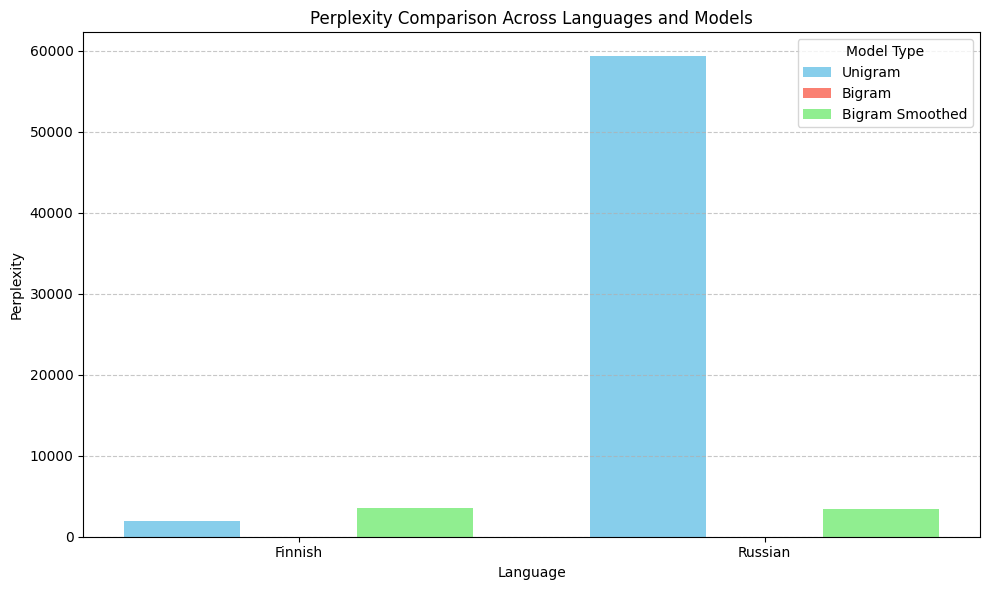

In [222]:
import matplotlib.pyplot as plt

perplexities = {
    'Finnish': {
        'Unigram': perplexity_fi_unigram,
        'Bigram': perplexity_fi_bigram,
        'Bigram Smoothed': perplexity_fi_bigram_smoothed,
    },
    'Russian': {
        'Unigram': perplexity_ru_unigram,
        'Bigram': perplexity_ru_bigram,
        'Bigram Smoothed': perplexity_ru_bigram_smoothed,
    },
}

# Preparing data for plotting
languages = list(perplexities.keys())
models = ['Unigram', 'Bigram', 'Bigram Smoothed']
x = np.arange(len(languages))  # x locations for the languages
width = 0.25  # Width of bars

values_unigram = [perplexities[language].get('Unigram', None) for language in languages]
values_bigram = [perplexities[language].get('Bigram', None) for language in languages]
values_bigram_smoothed = [perplexities[language].get('Bigram Smoothed', None) for language in languages]


# Double-checking all values are integers by converting any remaining None values to 0 explicitly and type-casting
values_unigram = [int(val) if val is not None else 0 for val in values_unigram]
values_bigram = [int(val) if val is not None else 0 for val in values_bigram]
values_bigram_smoothed = [int(val) if val is not None else 0 for val in values_bigram_smoothed]

# Plotting again
fig, ax = plt.subplots(figsize=(10, 6))

# Creating bars for each model type, side-by-side
ax.bar(x - width, values_unigram, width, label='Unigram', color='skyblue')
ax.bar(x, values_bigram, width, label='Bigram', color='salmon')
ax.bar(x + width, values_bigram_smoothed, width, label='Bigram Smoothed', color='lightgreen')

# Customizing plot
ax.set_xticks(x)
ax.set_xticklabels(languages)
ax.set_xlabel("Language")
ax.set_ylabel("Perplexity")
ax.set_title("Perplexity Comparison Across Languages and Models")
ax.legend(title="Model Type")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
